In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager

DATA_PATH = Path('/home/engaclew/neurogen')
columns = ['recording_filename', '5s_CTC', '1s_CTC', 'voc_chi', 'voc_dur_chi']

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
lena_measures = pd.read_csv(DATA_PATH / 'lena_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Read metadata
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'recording_filename']]
aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
lena_measures = lena_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

lena_color = '#6664b8'
aclew_color = '#E69F5C'

def analyze_clip_numbers(auto_data, manual_data, measure, metric='pearson', max_clips=15, n_iterations=1000):
    """
    Analyze how correlation or relative error stabilizes as number of clips increases
    """
    recordings = auto_data['recording_filename'].unique()
    results = []
    
    for n_clips in range(1, max_clips + 1):
        print(f"Processing n_clips = {n_clips}")
        metric_values = []
        
        for i in range(n_iterations):
            auto_sums = []
            manual_sums = []
            
            for recording in recordings:
                auto_rec = auto_data[auto_data['recording_filename'] == recording]
                manual_rec = manual_data[manual_data['recording_filename'] == recording]
                
                if len(auto_rec) >= n_clips:
                    indices = np.random.choice(len(auto_rec), size=n_clips, replace=True)
                    auto_sum = auto_rec.iloc[indices][measure].sum()
                    manual_sum = manual_rec.iloc[indices][measure].sum()
                    
                    auto_sums.append(auto_sum)
                    manual_sums.append(manual_sum)
            
            # Calculate metric
            if metric == 'pearson':
                if len(auto_sums) >= 2:  # Need at least 2 points for correlation
                    value = stats.pearsonr(auto_sums, manual_sums)[0]
                    metric_values.append(value)
            else:  # relative error
                errors = []
                for auto, manual in zip(auto_sums, manual_sums):
                    if manual == 0 and auto == 0:
                        error = 0  # Perfect agreement when both are zero
                    elif manual == 0:
                        error = 1  # Maximum error when manual is zero but auto isn't
                    else:
                        error = (auto - manual) / manual
                    errors.append(error)
                value = np.mean(errors)
                metric_values.append(value)
        
        results.append({
            'n_clips': n_clips,
            f'{metric}_mean': np.mean(metric_values),
            f'{metric}_std': np.std(metric_values),
            'ci_lower': np.percentile(metric_values, 2.5),
            'ci_upper': np.percentile(metric_values, 97.5)
        })
        
        print(f"  Mean {metric}: {np.mean(metric_values):.3f}")
    
    return pd.DataFrame(results)


def plot_metric_results(results, color, label, metric='pearson'):
    """
    Plot results with confidence intervals
    
    Parameters:
    -----------
    results : pd.DataFrame
        DataFrame containing results
    metric : str
        'pearson' for correlation or 'mape' for MAPE results
    """
    metric_col = f'{metric}_mean'
    
    plt.plot(results['n_clips'], results[metric_col], 'o-', color=color, 
             linewidth=2, label=f'{label} mean')
    
    plt.fill_between(results['n_clips'],
                     results['ci_lower'],
                     results['ci_upper'],
                     alpha=0.2, color=color,
                     label=f'{label} 95% CI')
    
    plt.xlabel('Number of Clips')
    plt.ylabel('Pearson Correlation' if metric == 'pearson' else 'Mean percentage error (%)')
    plt.title(f'{metric.title()} vs Number of Clips')
    plt.grid(True, alpha=0.3)
    
    
#metric = 'pearson'
#results_pearson = analyze_clip_numbers(aclew_measures, human_measures, 
#                                     measure='wc_adu', metric=metric, 
#                                     n_iterations=250)

#plt.figure(figsize=(10, 6))
#plot_metric_results(results_pearson, color=aclew_color, label='ACLEW', metric=metric)
#plt.tight_layout()
#plt.show()

In [3]:
lena_measures

,recording_filename,segment_onset,segment_offset,child_id,duration_its,voc_dur_chi,voc_chi,avg_voc_dur_chi,wc_fem,wc_mal,wc_adu,5s_CTC,CVC,speechlike_pitch,nonspeechlike_pitch,group_id
0,20180808_111213_024881.wav,1639000,1759000,2761,120000,5970.0,4,1492.500000,8.08,5.75,13.83,1,3.0,"[261.63669910440854, 241.9475919718303, 264.62...",[nan],low_risk
1,20180808_111213_024881.wav,2072000,2192000,2761,120000,600.0,1,600.000000,0.19,0.00,0.19,0,1.0,[409.53173528366494],[],low_risk
2,20180808_111213_024881.wav,2202000,2322000,2761,120000,9790.0,12,815.833333,0.00,0.00,0.00,0,12.0,"[335.9181469314461, 377.39021495424396, 357.61...",[],low_risk
3,20180808_111213_024881.wav,5817000,5937000,2761,120000,1940.0,3,646.666667,0.00,0.00,0.00,0,2.0,"[375.21069312786693, 512.2940051408225]",[502.913963139259],low_risk
4,20180808_111213_024881.wav,6837000,6957000,2761,120000,0.0,0,0.000000,0.00,0.00,0.00,0,0.0,[],[],low_risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,20230405_090552_045738_2.wav,39778000,39898000,7281,120000,6500.0,7,928.571429,29.32,5.96,35.28,3,6.0,"[422.11361048046336, 430.98076146620093, 371.0...",[472.60396483447676],autism_sibling
380,20230405_090552_045738_2.wav,41905000,42025000,7281,120000,14840.0,9,1648.888889,15.89,5.13,21.02,1,3.0,"[358.9117484626588, 688.4895189054052, 703.054...","[444.55227364629167, 575.3484108267455, 622.42...",autism_sibling
381,20230405_090552_045738_2.wav,45308000,45428000,7281,120000,14830.0,13,1140.769231,97.26,37.49,134.75,7,12.0,"[400.2000375106108, 437.58214001095376, 460.81...","[482.7574052821452, 353.50987737164735]",autism_sibling
382,20230405_090552_045738_2.wav,48958000,49078000,7281,120000,8300.0,11,754.545455,47.34,0.64,47.98,5,8.0,"[365.588178537485, 477.168463493645, 355.77418...","[394.97185734454, 696.9350990814755, 327.67730...",autism_sibling


Processing n_clips = 1
  Mean pearson: 0.852
Processing n_clips = 2
  Mean pearson: 0.872
Processing n_clips = 3
  Mean pearson: 0.893
Processing n_clips = 4
  Mean pearson: 0.900
Processing n_clips = 5
  Mean pearson: 0.908
Processing n_clips = 6
  Mean pearson: 0.915
Processing n_clips = 7
  Mean pearson: 0.918
Processing n_clips = 8
  Mean pearson: 0.925
Processing n_clips = 9
  Mean pearson: 0.926
Processing n_clips = 10
  Mean pearson: 0.907
Processing n_clips = 11
  Mean pearson: 0.908
Processing n_clips = 12
  Mean pearson: 0.909
Processing n_clips = 13
  Mean pearson: 0.916
Processing n_clips = 14
  Mean pearson: 0.916
Processing n_clips = 15
  Mean pearson: 0.919
Processing n_clips = 1
  Mean pearson: 0.755
Processing n_clips = 2
  Mean pearson: 0.789
Processing n_clips = 3
  Mean pearson: 0.803
Processing n_clips = 4
  Mean pearson: 0.813
Processing n_clips = 5
  Mean pearson: 0.811
Processing n_clips = 6
  Mean pearson: 0.826
Processing n_clips = 7
  Mean pearson: 0.829
Proc

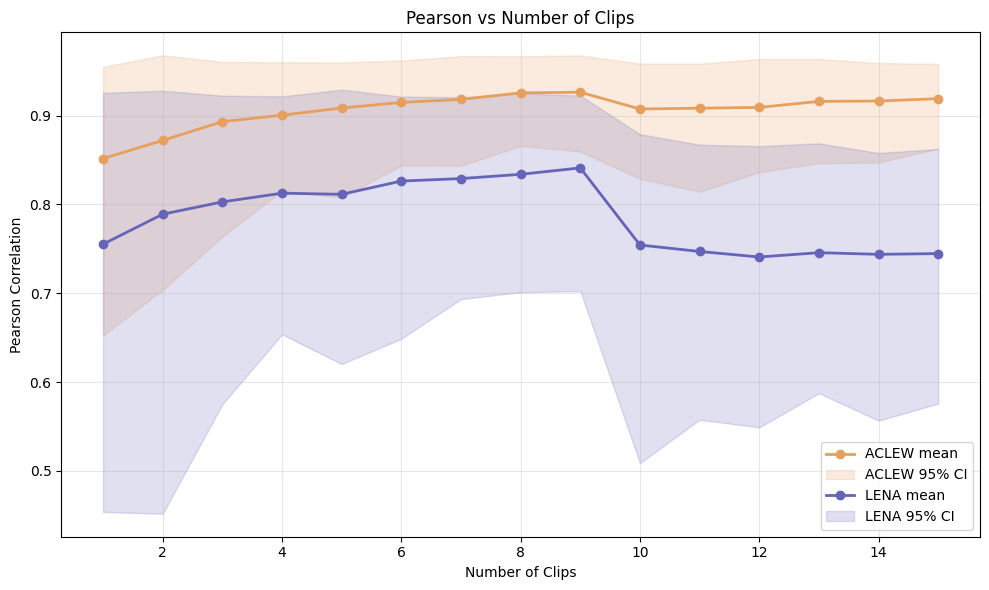

In [4]:
# AWC mean absolute percentage error: LENA vs ACLEW
metric='pearson'

plt.figure(figsize=(10, 6))
results_mape_aclew = analyze_clip_numbers(aclew_measures, human_measures, 
                                     measure='5s_CTC', metric=metric, 
                                     n_iterations=250)

results_mape_lena = analyze_clip_numbers(lena_measures, human_measures, 
                                     measure='5s_CTC', metric=metric, 
                                     n_iterations=250)
plot_metric_results(results_mape_aclew, color=aclew_color, label='ACLEW', metric=metric)
plot_metric_results(results_mape_lena, color=lena_color, label='LENA', metric=metric)
plt.legend()
plt.tight_layout()
plt.show()